In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5),(0.5))
# ])

mnist_data = datasets.MNIST(root="./data", train=True, download=True,transform = transform)

data_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size=64,
                                          shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
dataiter = iter(data_loader)
images,labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class AutoEncoder_Linear(nn.Module):
  def __init__(self):
    super().__init__()
    #N, 784
    self.encoder = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3) # -> N,3
        
    ) #Reduce the size from N,784 -> N, 128
  

    self.decoder = nn.Sequential(
        nn.Linear(3,12), 
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28), #From N,3 -> N,784
        nn.Sigmoid()
        
    )

  
  # NOTE ! [-1,1] -> nn.Tanh if we apply normalization
  def forward(self,x):
    encoder = self.encoder(x)
    decoder = self.decoder(encoder)
    return decoder

Using convolutional

In [5]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    #N,1, 28, 28
    #NOTE ! CAN BE TRICKY BECAUSE WE NEED TO KNOW CORRECT SHAPE AND INPUT AND OUTPIT CHANNEL
    self.encoder = nn.Sequential( # WE INCREASE CHANNELS, BUT REDUCE SIZE TO 1 PIXEL
        nn.Conv2d(1,16,3, stride=2, padding=1), #N , 16, 14, 14
        nn.ReLU(),
        nn.Conv2d(16,32,3, stride=2, padding=1), # N, 32 , 7, 7
        nn.ReLU(),
        nn.Conv2d(32,64,7) # N, 64, 1, 1 
        
    ) #Reduce the size from N,784 -> N, 128
  
    # N, 64, 1, 1 
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64,32,7),  # N, 32, 7, 7
        nn.ReLU(),
        nn.ConvTranspose2d(32,16,3, stride=2, padding=1, output_padding=1), # N 16, 13, 13 # TO COMPENSATE ALL OF THESE WE USE STRIDE AND PADDING. SO WE GET  N 16, 14, 14
        nn.ReLU(),
        nn.ConvTranspose2d(16,1,3, stride=2, padding=1, output_padding=1), # ON THE OUTPUT WE GET N, 1, 28,28
        nn.Sigmoid()
        
    )

  
  # NOTE ! [-1,1] -> nn.Tanh if we apply normalization
  def forward(self,x):
    encoder = self.encoder(x)
    decoder = self.decoder(encoder)
    return decoder

#nn.MaxPool2d -> nn.MaxUnpool2d (can be better used to decode)

In [6]:
model = AutoEncoder()
crieterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [7]:
num_epochs = 5
outputs=[]
for epoch in range(num_epochs):
  for (img,_) in data_loader:
    #img = img.reshape(-1, 28*28)
    recon = model(img)
    loss = crieterion(recon,img) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
  outputs.append((epoch,img,recon))

Epoch: 1, Loss: 0.0091
Epoch: 2, Loss: 0.0070
Epoch: 3, Loss: 0.0047
Epoch: 4, Loss: 0.0037
Epoch: 5, Loss: 0.0034


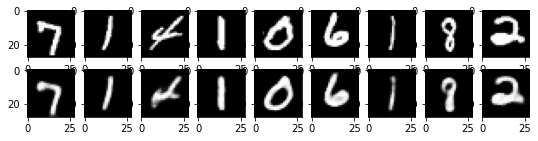

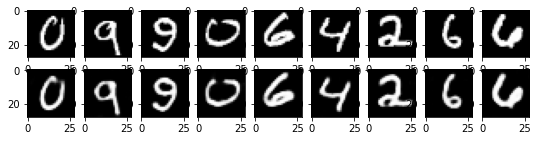

In [8]:
for k in range(0, num_epochs,4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs=outputs[k][1].detach().numpy()
  recon=outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break #plotting first 9 pics
    plt.subplot(2,9,1+i)
    #item = item.reshape(-1,28,28) #item will become 1,28,28
    plt.imshow(item[0])
  
  for i, item in enumerate(recon):
    if i>=9: break
    plt.subplot(2,9,9+i+1) # row_length + i + 1
    item = item.reshape(-1,28,28) # item: 1, 28, 28
    plt.imshow(item[0])



In [9]:
class AutoEncoder_Linear(nn.Module):
  def __init__(self):
    super().__init__()
    #N, 784
    self.encoder = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3) # -> N,3
        
    ) #Reduce the size from N,784 -> N, 128
  

    self.decoder = nn.Sequential(
        nn.Linear(3,12), 
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28), #From N,3 -> N,784
        nn.Sigmoid()
        
    )

  
  # NOTE ! [-1,1] -> nn.Tanh if we apply normalization
  def forward(self,x):
    encoder = self.encoder(x)
    decoder = self.decoder(encoder)
    return decoder

In [12]:
model = AutoEncoder_Linear()
crieterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [13]:
num_epochs = 5
outputs=[]
for epoch in range(num_epochs):
  for (img,_) in data_loader:
    img = img.reshape(-1, 28*28)
    recon = model(img)
    loss = crieterion(recon,img) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
  outputs.append((epoch,img,recon))

Epoch: 1, Loss: 0.0524
Epoch: 2, Loss: 0.0404
Epoch: 3, Loss: 0.0446
Epoch: 4, Loss: 0.0349
Epoch: 5, Loss: 0.0359


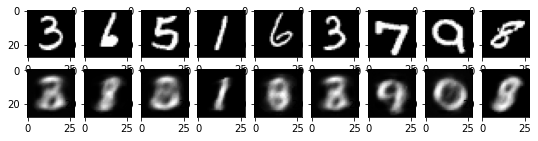

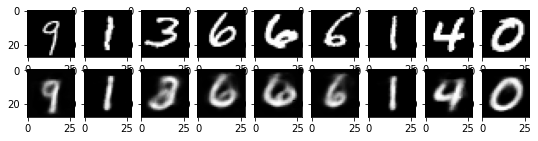

In [14]:
for k in range(0, num_epochs,4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs=outputs[k][1].detach().numpy()
  recon=outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break #plotting first 9 pics
    plt.subplot(2,9,1+i)
    item = item.reshape(-1,28,28) #item will become 1,28,28
    plt.imshow(item[0])
  
  for i, item in enumerate(recon):
    if i>=9: break
    plt.subplot(2,9,9+i+1) # row_length + i + 1
    item = item.reshape(-1,28,28) # item: 1, 28, 28
    plt.imshow(item[0])

